In [7]:
# Uncomment if not installed
# !pip install lightgbm

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [11]:
# Load dataset
df = pd.read_csv("dataset.csv")

# Convert to datetime with errors='coerce' to handle bad entries
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

# Drop rows where Date couldn't be converted
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Create temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Create lag features
df['Close_lag_1'] = df['Close'].shift(1)
df['Close_lag_2'] = df['Close'].shift(2)
df['Close_lag_3'] = df['Close'].shift(3)

# Drop missing rows (caused by shifting)
df = df.dropna().reset_index(drop=True)

df.head()


,level_0,index,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,Month,Day,DayOfWeek,WeekOfYear,Close_lag_1,Close_lag_2,Close_lag_3
0,3,3,2020-05-11 04:00:00+00:00,1702.300049,1704.500000,1690.199951,1695.300049,749,0.0,0.0,2020,5,11,0,20,1709.900024,1721.800049,1684.199951
1,4,4,2020-05-12 04:00:00+00:00,1699.300049,1713.099976,1699.300049,1704.400024,324,0.0,0.0,2020,5,12,1,20,1695.300049,1709.900024,1721.800049
2,5,5,2020-05-13 04:00:00+00:00,1702.000000,1721.300049,1701.900024,1713.900024,431,0.0,0.0,2020,5,13,2,20,1704.400024,1695.300049,1709.900024
3,6,6,2020-05-14 04:00:00+00:00,1724.300049,1743.099976,1720.500000,1738.099976,672,0.0,0.0,2020,5,14,3,20,1713.900024,1704.400024,1695.300049
4,7,7,2020-05-15 04:00:00+00:00,1739.699951,1753.400024,1739.699951,1753.400024,719,0.0,0.0,2020,5,15,4,20,1738.099976,1713.900024,1704.400024


In [15]:
# Define features and target
feature_cols = ['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3']
X = df[feature_cols]
y = df['Close']

# Train-test split (keep time order)
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
dates_test = df['Date'][split_index:]

In [16]:
# Train LightGBM Regressor
model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 8
[LightGBM] [Info] Start training from score 1874.527786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=500,
              random_state=42)

In [17]:
# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 433.3963551595378
R² Score: -1.550869921996056


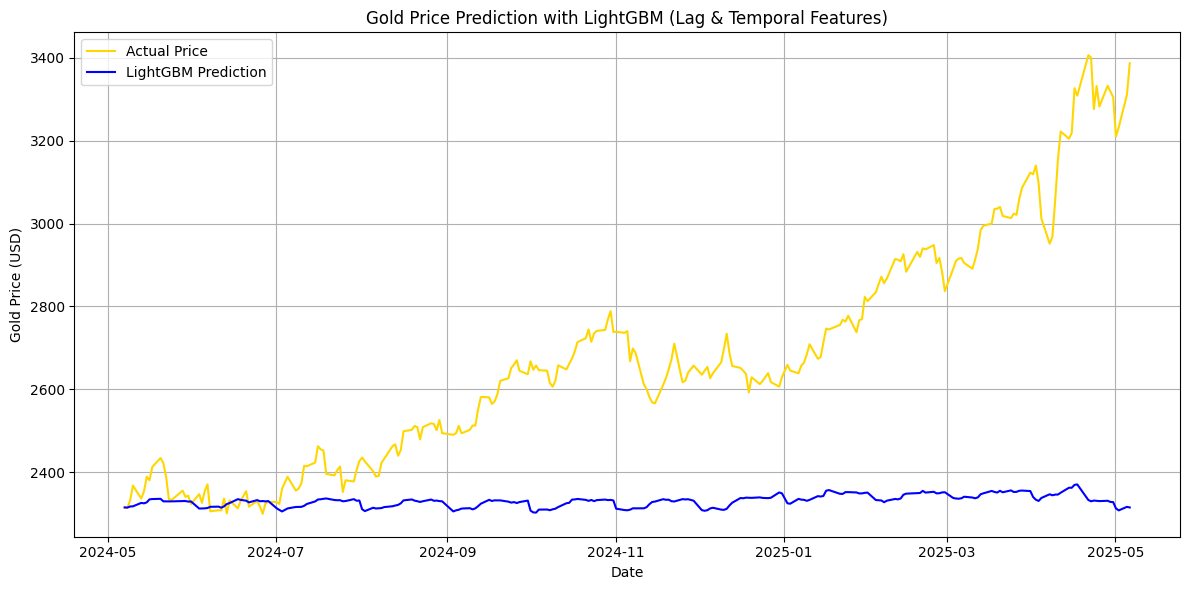

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label='Actual Price', color='gold')
plt.plot(dates_test, y_pred, label='LightGBM Prediction', color='blue')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.title('Gold Price Prediction with LightGBM (Lag & Temporal Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()